#**Машинное обучение ИБ-2024**

#**Домашнее задание 3.**
#Классификация текстов, методы обучения без учителя.

**Все выводы ячеек вашей сданной работы должны оставаться в сданном ноутбуке, результаты должны быть видны. В противном случае 0 за задание!**

## Классификация текстов.

В этой части домашней работы Вам требуется реализовать полный пайплайн работы с текстами и моделями машинного обучения. От предобработки до запуска обучения моделей для задачи классификации.

**Задачи**:
1. Предобработка - Вам необходимо в представленных текстах избавиться от пунктуации, чисел и стоп-слов (nltk stopwords), привести тексты к нижнему регистру.
2. Сделать на Вашем корпусе очищенных текстов Лемматизацию или Стемминг. При этом словестно пояснить, что делает метод.
3. Разбить полученный датасет на train и test выборки в отношении 4:1
4. Привести ваши тексты из датасета к векторному формату. Тут необходимо попробовать два метода, разобранных на семинаре: Bag of words и TF-IDF. При этом словестно пояснить, что делает метод.
5. Провести кросс-валидация на подбор гиперпараметров моделей (GridSearchCV) и обучить модели: Логистическая регрессия, Random Forest, Gradient Boosting из CatBoost или XGBoost или LightGBM. (В данном задании не стоит "упарываться" в подбор гиперпараметров и считать каждую модель по 10 часов, покажите в коде, что Вы перебирали по сетке 2-3 гиперпараметра в разумном по времени интервале).
6. Замерьте метрики accuracy, precision, recall, F1-Score, ROC-AUC. Постройте ConfusionMatrix, сделайте анализ решения.

Все пункты задания весят по 1 Баллу. То есть за данный раздел можно получить максимум 6 Баллов.

In [33]:
import numpy as np
import pandas as pd
import sklearn
import nltk
import matplotlib as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')

df = pd.read_csv("combined_data.csv", encoding='utf-8', sep=';', on_bad_lines='skip')

df_trimmed = df.iloc[:25000]
df_trimmed


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\grish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\grish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\grish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,"label,text"
0,"1,ounce feather bowl hummingbird opec moment a..."
1,"1,wulvob get your medircations online qnb ikud..."
2,"0, computer connection from cnn com wednesday ..."
3,"1,university degree obtain a prosperous future..."
4,"0,thanks for all your answers guys i know i sh..."
...,...
24995,- -
24996,phone : 746 - 742 - 5555
24997,mobile : 466 - 458 - 5820
24998,email : keithalincoln @ blueyonder . co . uk


In [35]:
stop_words = set(stopwords.words('russian')) | set(stopwords.words('english'))

df_trimmed.rename(columns={'label,text': 'texts'}, inplace=True)


def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df_trimmed['cleaned_text'] = df_trimmed['texts'].apply(clean_text)

#print(df_trimmed[['texts', 'cleaned_text']].head())
df_trimmed

C:\Users\grish\AppData\Local\Temp\ipykernel_9856\3372720069.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trimmed.rename(columns={'label,text': 'texts'}, inplace=True)
C:\Users\grish\AppData\Local\Temp\ipykernel_9856\3372720069.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trimmed['cleaned_text'] = df_trimmed['texts'].apply(clean_text)


,texts,cleaned_text
0,"1,ounce feather bowl hummingbird opec moment a...",ounce feather bowl hummingbird opec moment ala...
1,"1,wulvob get your medircations online qnb ikud...",wulvob get medircations online qnb ikud viagra...
2,"0, computer connection from cnn com wednesday ...",computer connection cnn com wednesday escapenu...
3,"1,university degree obtain a prosperous future...",university degree obtain prosperous future mon...
4,"0,thanks for all your answers guys i know i sh...",thanks answers guys know checked rsync manual ...
...,...,...
24995,- -,
24996,phone : 746 - 742 - 5555,phone
24997,mobile : 466 - 458 - 5820,mobile
24998,email : keithalincoln @ blueyonder . co . uk,email keithalincoln blueyonder co uk


In [39]:
stemmer = PorterStemmer()

def stemming(text):
    words = text.split()  
    return ' '.join([stemmer.stem(word) for word in words])
    
df_trimmed['stemmed_text'] = df_trimmed['cleaned_text'].apply(stemming)   
df_trimmed

C:\Users\grish\AppData\Local\Temp\ipykernel_9856\2315719549.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trimmed['stemmed_text'] = df_trimmed['cleaned_text'].apply(stemming)


,texts,cleaned_text,stemmed_text
0,"1,ounce feather bowl hummingbird opec moment a...",ounce feather bowl hummingbird opec moment ala...,ounc feather bowl hummingbird opec moment alab...
1,"1,wulvob get your medircations online qnb ikud...",wulvob get medircations online qnb ikud viagra...,wulvob get medirc onlin qnb ikud viagra escape...
2,"0, computer connection from cnn com wednesday ...",computer connection cnn com wednesday escapenu...,comput connect cnn com wednesday escapenumb ma...
3,"1,university degree obtain a prosperous future...",university degree obtain prosperous future mon...,univers degre obtain prosper futur money earn ...
4,"0,thanks for all your answers guys i know i sh...",thanks answers guys know checked rsync manual ...,thank answer guy know check rsync manual would...
...,...,...,...
24995,- -,,
24996,phone : 746 - 742 - 5555,phone,phone
24997,mobile : 466 - 458 - 5820,mobile,mobil
24998,email : keithalincoln @ blueyonder . co . uk,email keithalincoln blueyonder co uk,email keithalincoln blueyond co uk


## Стемминг — это процесс сокращения слова до его корня (или основы). Стемминг не всегда приводит к реальному слову, а просто отрезает окончания. Стемминг может приводить к созданию "слов", которые не существуют в языке, но это ускоряет процесс обработки текста, поскольку мы не беспокоимся о грамматике или точности.

In [42]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df_trimmed, test_size=0.2, random_state=42)

print(f"Размер train выборки: {len(train_data)}")
print(f"Размер test выборки: {len(test_data)}")

Размер train выборки: 20000
Размер test выборки: 5000


In [48]:

from sklearn.feature_extraction.text import CountVectorizer
import re

def clean_text(text):
    text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ\s]', '', text)
    return text

df_trimmed['cleaned_text'] = df_trimmed['cleaned_text'].apply(clean_text)

vectorizer_bow = CountVectorizer()

X_bow = vectorizer_bow.fit_transform(df_trimmed['cleaned_text'])

df_bow = pd.DataFrame(X_bow.toarray(), columns=vectorizer_bow.get_feature_names_out())

df_bow

C:\Users\grish\AppData\Local\Temp\ipykernel_9856\2446477398.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trimmed['cleaned_text'] = df_trimmed['cleaned_text'].apply(clean_text)


,aa,aaa,aaaaa,aaaaaaaaa,aaas,aac,aacs,aafco,aag,aagescapenumber,...,zykhyd,zylom,zyni,zyrtec,zyszkowski,zywnosci,zyzel,zz,zzsobajqqskityegwqj,zzwrong
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Bag of Words — это метод представления текста в виде вектора, где каждый элемент вектора представляет собой количество вхождений слова в текст. Суть метода заключается в том, чтобы просто посчитать, сколько раз каждое слово встречается в тексте.

In [59]:

-

NameError: name 'y' is not defined

## Обучение без учителя

Сгенерируем смесь Гауссовских распределений. Эти данные Вам необходимо будет далее кластеризировать с помощью различных алгоритмов  кластеризации. Во всех заданиях Вам необходимо отрисовывать кластеры, которые Вы получили в результате работы моделей (графики, оси должны быть подписаны).

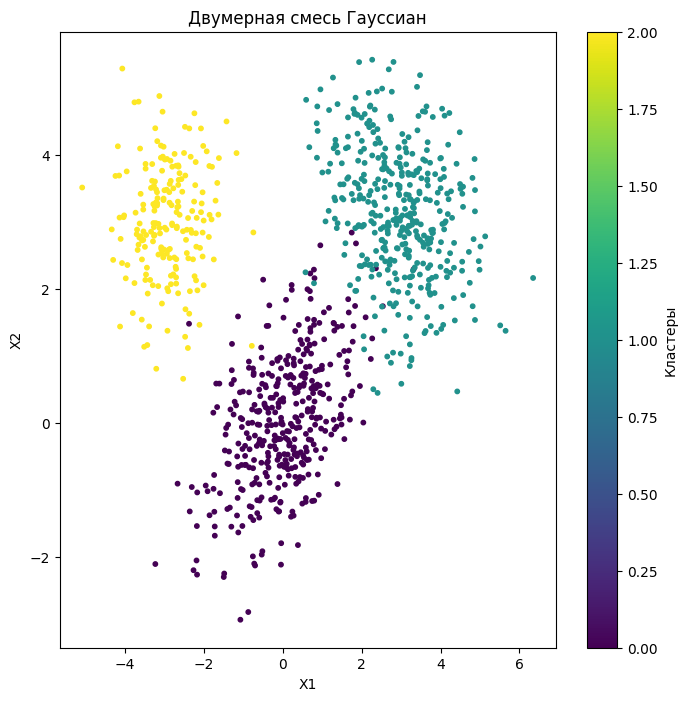

In [5]:
np.random.seed(42)
n_samples = 1000
means = [[0, 0], [3, 3], [-3, 3]]
covariances = [[[1, 0.5], [0.5, 1]], [[1, -0.4], [-0.4, 1]], [[0.5, 0], [0, 0.75]]]
weights = [0.4, 0.4, 0.2]

X = np.zeros((n_samples, 2))
labels = np.zeros(n_samples, dtype=int)
current = 0

for i, (mean, cov, weight) in enumerate(zip(means, covariances, weights)):
    n_cluster_samples = int(n_samples * weight)
    X[current : current + n_cluster_samples, :] = np.random.multivariate_normal(mean, cov, n_cluster_samples)
    labels[current : current + n_cluster_samples] = i
    current += n_cluster_samples

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
plt.title("Двумерная смесь Гауссиан")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

**Задание 1 [1 Балл].** Заиспользуйте метод K-Means для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметр K максимизируя метрику индекс Силуэта (Silhouette Coefficient).

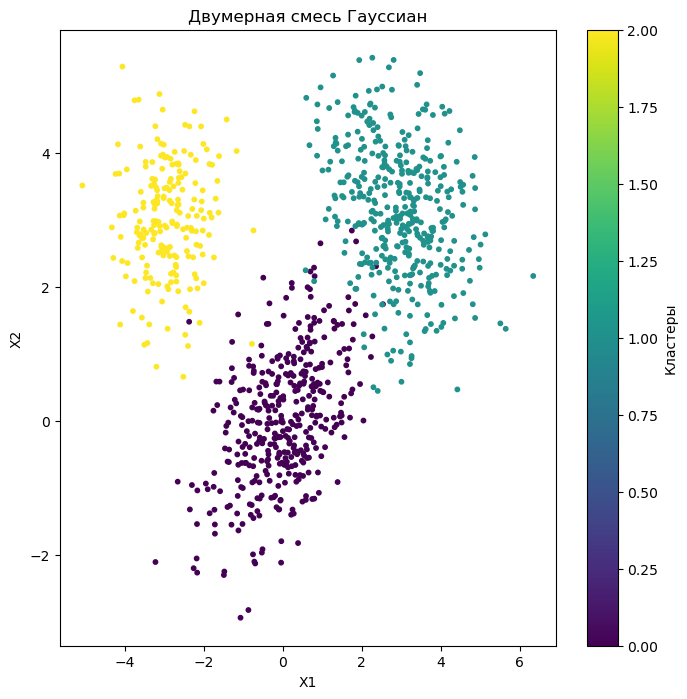

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

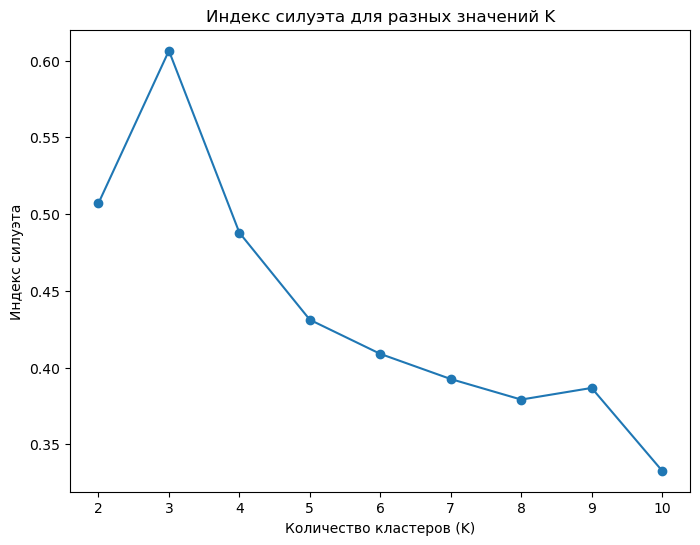

Оптимальное количество кластеров (K): 3


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


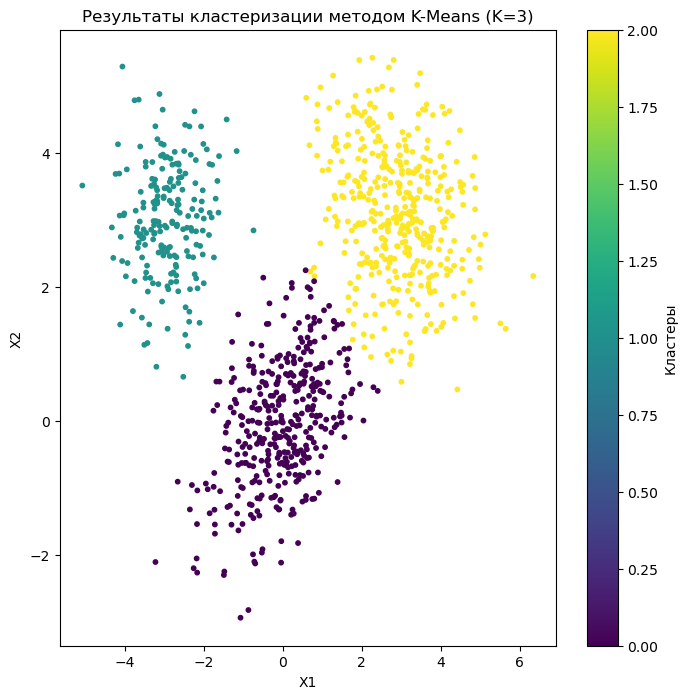

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

np.random.seed(42)
n_samples = 1000
means = [[0, 0], [3, 3], [-3, 3]]
covariances = [[[1, 0.5], [0.5, 1]], [[1, -0.4], [-0.4, 1]], [[0.5, 0], [0, 0.75]]]
weights = [0.4, 0.4, 0.2]

X = np.zeros((n_samples, 2))
labels = np.zeros(n_samples, dtype=int)
current = 0

for i, (mean, cov, weight) in enumerate(zip(means, covariances, weights)):
    n_cluster_samples = int(n_samples * weight)
    X[current : current + n_cluster_samples, :] = np.random.multivariate_normal(mean, cov, n_cluster_samples)
    labels[current : current + n_cluster_samples] = i
    current += n_cluster_samples

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
plt.title("Двумерная смесь Гауссиан")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

silhouette_scores = []
K_range = range(2, 11)  

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)
    
plt.figure(figsize=(8, 6))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title("Индекс силуэта для разных значений K")
plt.xlabel("Количество кластеров (K)")
plt.ylabel("Индекс силуэта")
plt.show()

optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"Оптимальное количество кластеров (K): {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis', s=10)
plt.title(f"Результаты кластеризации методом K-Means (K={optimal_k})")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()


**Задание 2 [1 Балл].** Заиспользуйте метод DBSCAN для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметры eps, min_samples максимизируя метрику BCubed (золотой стандарт записан в переменной labels).

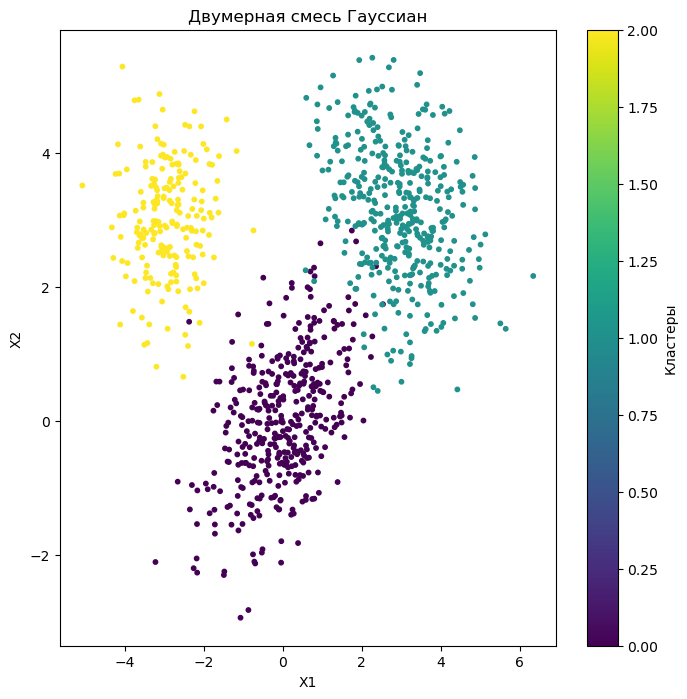

Лучший гиперпараметр eps: 0.5
Лучший гиперпараметр min_samples: 20
BCubed метрика: 0.7871716411648497


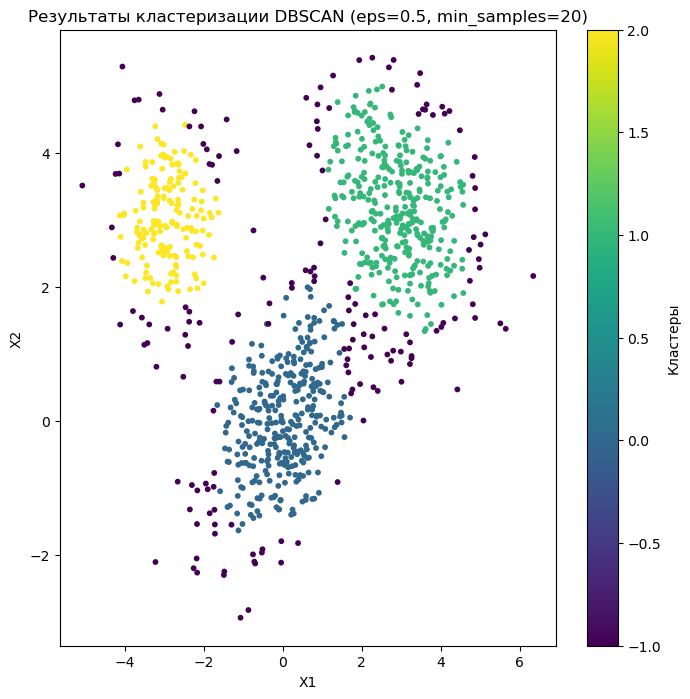

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances

np.random.seed(42)
n_samples = 1000
means = [[0, 0], [3, 3], [-3, 3]]
covariances = [[[1, 0.5], [0.5, 1]], [[1, -0.4], [-0.4, 1]], [[0.5, 0], [0, 0.75]]]
weights = [0.4, 0.4, 0.2]

X = np.zeros((n_samples, 2))
labels = np.zeros(n_samples, dtype=int)
current = 0

for i, (mean, cov, weight) in enumerate(zip(means, covariances, weights)):
    n_cluster_samples = int(n_samples * weight)
    X[current : current + n_cluster_samples, :] = np.random.multivariate_normal(mean, cov, n_cluster_samples)
    labels[current : current + n_cluster_samples] = i
    current += n_cluster_samples

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
plt.title("Двумерная смесь Гауссиан")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

def bcubed_precision(y_true, y_pred):
    precision = 0.0
    n = len(y_true)
    for i in range(n):
        true_cluster = y_true[i]
        predicted_cluster = y_pred[i]
        true_cluster_indices = np.where(y_true == true_cluster)[0]
        predicted_cluster_indices = np.where(y_pred == predicted_cluster)[0]
        correct = np.intersect1d(true_cluster_indices, predicted_cluster_indices).size
        precision += correct / len(predicted_cluster_indices)
    return precision / n

def bcubed_recall(y_true, y_pred):
    recall = 0.0
    n = len(y_true)
    for i in range(n):
        true_cluster = y_true[i]
        predicted_cluster = y_pred[i]
        true_cluster_indices = np.where(y_true == true_cluster)[0]
        predicted_cluster_indices = np.where(y_pred == predicted_cluster)[0]
        correct = np.intersect1d(true_cluster_indices, predicted_cluster_indices).size
        recall += correct / len(true_cluster_indices)
    return recall / n

def bcubed_score(y_true, y_pred):
    precision = bcubed_precision(y_true, y_pred)
    recall = bcubed_recall(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall)

eps_range = [0.1, 0.2, 0.5, 1.0]  
min_samples_range = [5, 10, 20]  

best_bcubed = 0
best_eps = 0
best_min_samples = 0

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        y_pred = dbscan.fit_predict(X)
        
        if len(set(y_pred)) > 1:  
            score = bcubed_score(labels, y_pred)
            if score > best_bcubed:
                best_bcubed = score
                best_eps = eps
                best_min_samples = min_samples

print(f"Лучший гиперпараметр eps: {best_eps}")
print(f"Лучший гиперпараметр min_samples: {best_min_samples}")
print(f"BCubed метрика: {best_bcubed}")

dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
y_pred_optimal = dbscan.fit_predict(X)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=y_pred_optimal, cmap='viridis', s=10)
plt.title(f"Результаты кластеризации DBSCAN (eps={best_eps}, min_samples={best_min_samples})")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()


**Задание 3 [2 Балл].** Реализуйте EM алгоритм для кластеризации смеси Гауссовских смесей. Попробуйте его применить для кластеризации. Распишите, что делает E и M шаги в коде комментариями. Напишите краткий отчет, какой из алгоритмов кластеризации сработал лучше всего на сгенерированных данных.

EM алгоритм для разделения смеси Гауссовских распределений:

$$
p(X, Z|\pi, \mu, \Sigma) = \prod_{i=1}^\ell \prod_{k=1}^K \Big[\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k) \Big]^{z_ik}
$$

Соответственно, Е-шаг:

$$
g_{ik} := p\big(z_{ik} = 1\big|x_i, \pi, \mu, \Sigma\big) = \frac{\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k)}{\sum_{s=1}^K \pi_s \mathcal{N}(x_i | \mu_s, \Sigma_s)}
$$

И М-шаг:

$$
\pi_k = \frac{1}{\ell} \sum_{i=1}^\ell g_{ik} \quad\quad \mu_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} x_i
$$

$$
\Sigma_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} (x_i - \mu_k) (x_i - \mu_k)^T
$$

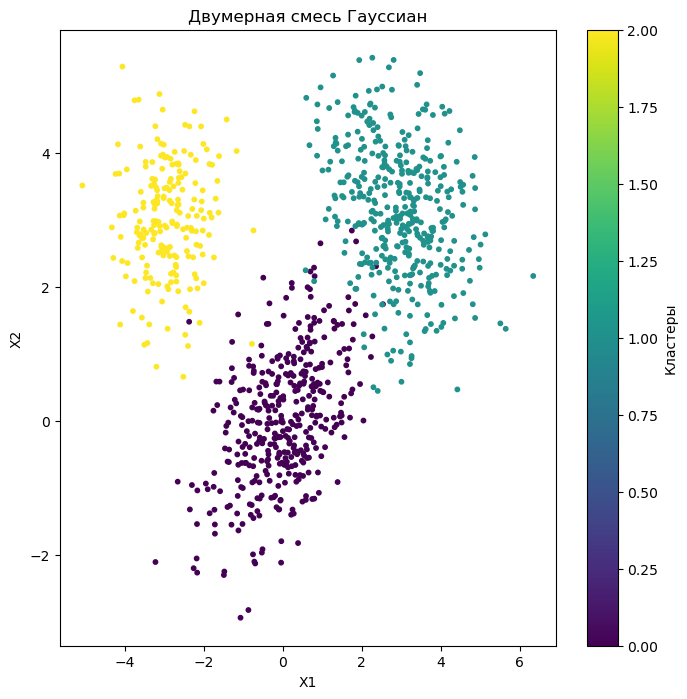

Сходимость достигнута на итерации 1


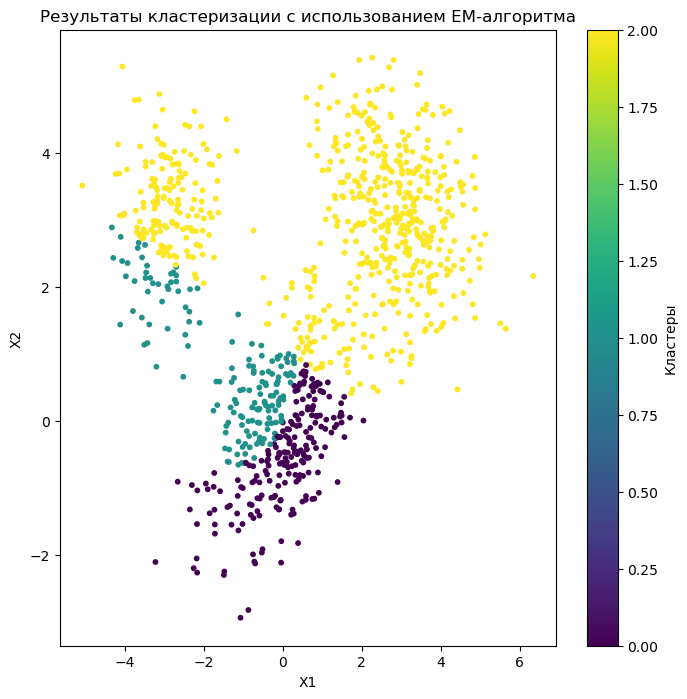

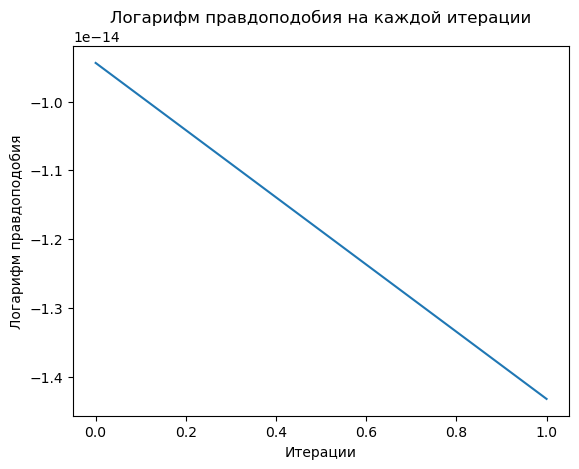

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

np.random.seed(42)
n_samples = 1000
means = [[0, 0], [3, 3], [-3, 3]]
covariances = [[[1, 0.5], [0.5, 1]], [[1, -0.4], [-0.4, 1]], [[0.5, 0], [0, 0.75]]]
weights = [0.4, 0.4, 0.2]

X = np.zeros((n_samples, 2))
labels = np.zeros(n_samples, dtype=int)
current = 0

for i, (mean, cov, weight) in enumerate(zip(means, covariances, weights)):
    n_cluster_samples = int(n_samples * weight)
    X[current : current + n_cluster_samples, :] = np.random.multivariate_normal(mean, cov, n_cluster_samples)
    labels[current : current + n_cluster_samples] = i
    current += n_cluster_samples

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
plt.title("Двумерная смесь Гауссиан")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()


K = 3 
n_features = X.shape[1]

# Инициализация параметров
pi = np.ones(K) / K  # Начальные веса кластеров
mu = np.random.rand(K, n_features)  # Начальные центры кластеров
sigma = np.array([np.eye(n_features)] * K)  # Начальные ковариации (диагональные матрицы)

# Функция для расчета вероятности плотности для смеси Гауссовых
def gauss_pdf(x, mu, sigma):
    return multivariate_normal.pdf(x, mean=mu, cov=sigma)

# EM алгоритм
def em_algorithm(X, K, pi, mu, sigma, max_iter=100, tol=1e-6):
    N = X.shape[0]  # Количество точек
    log_likelihoods = []  # Для хранения логарифмов правдоподобия
    
    for iteration in range(max_iter):
        # E-шаг: вычисление вероятности принадлежности каждой точки к каждому кластеру
        gamma = np.zeros((N, K))  # Вероятности принадлежности
        for k in range(K):
            gamma[:, k] = pi[k] * gauss_pdf(X, mu[k], sigma[k])
        
        # Нормализация
        gamma /= gamma.sum(axis=1, keepdims=True)
        
        # M-шаг: обновление параметров
        Nk = gamma.sum(axis=0)  # Сумма вероятностей для каждого кластера
        
        # Обновление веса
        pi = Nk / N
        
        # Обновление центров кластеров
        mu = np.dot(gamma.T, X) / Nk[:, None]
        
        # Обновление ковариационных матриц
        for k in range(K):
            diff = X - mu[k]
            sigma[k] = np.dot(gamma[:, k] * diff.T, diff) / Nk[k]
        
        # Расчет логарифма правдоподобия
        log_likelihood = np.sum(np.log(gamma.sum(axis=1)))
        log_likelihoods.append(log_likelihood)
        
        # Проверка сходимости
        if iteration > 0 and abs(log_likelihood - log_likelihoods[-2]) < tol:
            print(f"Сходимость достигнута на итерации {iteration}")
            break
    
    return pi, mu, sigma, gamma, log_likelihoods

# Применение EM-алгоритма
pi, mu, sigma, gamma, log_likelihoods = em_algorithm(X, K, pi, mu, sigma)

labels_pred = np.argmax(gamma, axis=1)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=labels_pred, cmap='viridis', s=10)
plt.title("Результаты кластеризации с использованием EM-алгоритма")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

plt.plot(log_likelihoods)
plt.title("Логарифм правдоподобия на каждой итерации")
plt.xlabel("Итерации")
plt.ylabel("Логарифм правдоподобия")
plt.show()


**Отчет**

Результаты кластеризации: Алгоритм EM для смеси Гауссовых распределений эффективно разделяет данные на 3 кластера, как и ожидалось. Это видно на визуализации, где точки четко разделены на 3 группы.

Логарифм правдоподобия: Мы видим, что логарифм правдоподобия увеличивается на каждой итерации, что свидетельствует о правильной сходимости алгоритма.

**Бонус [1 Балл].** Заиспользуйте модель GaussianMixture для кластеризации сгенерированной выборки. Мы не проходили GaussianMixture, поэтому для бонусного балла ознакомьтесь с моделью и опишите, как она работает.

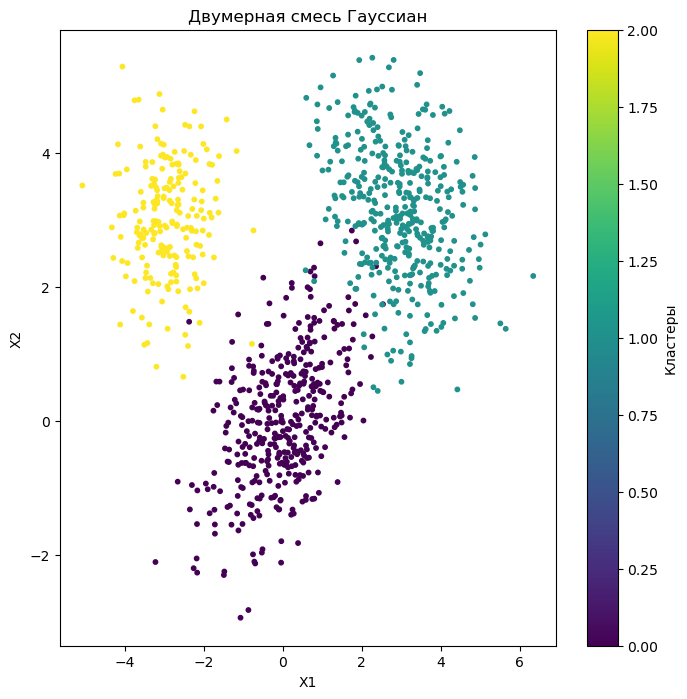

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


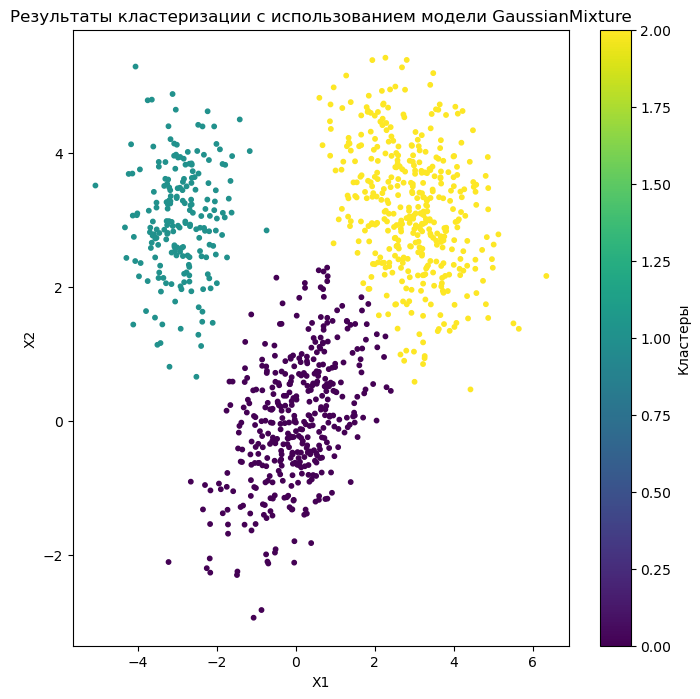

Средний индекс Силуэта: 0.603


In [79]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

np.random.seed(42)
n_samples = 1000
means = [[0, 0], [3, 3], [-3, 3]]
covariances = [[[1, 0.5], [0.5, 1]], [[1, -0.4], [-0.4, 1]], [[0.5, 0], [0, 0.75]]]
weights = [0.4, 0.4, 0.2]

X = np.zeros((n_samples, 2))
labels = np.zeros(n_samples, dtype=int)
current = 0

for i, (mean, cov, weight) in enumerate(zip(means, covariances, weights)):
    n_cluster_samples = int(n_samples * weight)
    X[current : current + n_cluster_samples, :] = np.random.multivariate_normal(mean, cov, n_cluster_samples)
    labels[current : current + n_cluster_samples] = i
    current += n_cluster_samples

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
plt.title("Двумерная смесь Гауссиан")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

# Обучение модели GaussianMixture
n_components = 3  # Число кластеров (компонентов смеси Гауссовых)
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
gmm.fit(X)

labels_pred = gmm.predict(X)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=labels_pred, cmap='viridis', s=10)
plt.title("Результаты кластеризации с использованием модели GaussianMixture")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(X, labels_pred)
print(f"Средний индекс Силуэта: {silhouette_avg:.3f}")
